# Emotion recognition using Emo-DB dataset and CNN trained in pytorch

### Database: Emo-DB database (free) 7 emotions
The data can be downloaded from http://emodb.bilderbar.info/index-1024.html

Code of emotions

W->Anger->Wut

L->Boredom->Langeweile

E->Disgust->Ekel

A->Anxiety/Fear->Angst

F->Happiness->Freude

T->Sadness->Trauer

N->Neutral


![image.png](http://iis-projects.ee.ethz.ch/images/thumb/a/a6/Emotions-on-arousal-valence-space.jpg/450px-Emotions-on-arousal-valence-space.jpg)

In [1]:
import requests 
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import itertools
import sys
sys.path.append("../")
import time
from plots_examples import plot_confusion_matrix, plot_ROC, plot_histogram


# disvoice imports
from phonation.phonation import Phonation
from articulation.articulation import Articulation
from prosody.prosody import Prosody
from phonological.phonological import Phonological
from replearning.replearning import RepLearning


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# torch imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as data

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

Using TensorFlow backend.
/home/camilo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/camilo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/camilo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/camilo/anaconda3/lib/python3.6/site-packages/tenso

## Download and unzip data


In [2]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
            
PATH_data="http://emodb.bilderbar.info/download/download.zip"

In [3]:
download_url(PATH_data, "./download.zip")

In [4]:
with zipfile.ZipFile("./download.zip", 'r') as zip_ref:
    zip_ref.extractall("./emo-db/")

## prepare labels from the dataset

we will get labels for two classification problems: 

1. high vs. low arousal emotions
2. positive vs. negative emotions


In [5]:
PATH_AUDIO=os.path.abspath("./emo-db/wav")+"/"
labelsd='WLEAFTN'
labelshl=  [0, 1, 0, 0, 0, 1, 1] # 0 high arousal emotion, 1 low arousal emotions
labelspn=  [0, 0, 0, 0, 1, 0, 1] # 0 negative valence emotion, 1 positive valence emotion

hf=os.listdir(PATH_AUDIO)
hf.sort()

yArousal=np.zeros(len(hf))
yValence=np.zeros(len(hf))
for j in range(len(hf)):
    name_file=hf[j]
    label=hf[j][5]
    poslabel=labelsd.find(label)
    yArousal[j]=labelshl[poslabel]
    yValence[j]=labelspn[poslabel]

## compute features using disvoice: phonation, articulation, prosody, phonological

In [6]:
phonationf=Phonation()
articulationf=Articulation()
prosodyf=Prosody()
phonologicalf=Phonological()
replearningf=RepLearning('CAE')

Instructions for updating:
Colocations handled automatically by placer.


/home/camilo/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## phonation features 

In [7]:
Xphonation=phonationf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="torch")
print(Xphonation.size())

Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [00:24<00:12, 13.37it/s]../phonation/phonation.py:161: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [00:33<00:00, 15.77it/s]

torch.Size([535, 28])


## articulation features 

In [8]:
Xarticulation=articulationf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="torch")
print(Xarticulation.size())

Processing 03a01Fa.wav:   0%|          | 0/535 [00:00<?, ?it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [05:54<02:51,  1.04s/it]../articulation/articulation.py:264: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [08:29<00:00,  1.05it/s]

torch.Size([535, 488])


## prosody features 

In [9]:
Xprosody=prosodyf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="torch")
print(Xprosody.size())

Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [02:20<00:57,  2.85it/s]../prosody/prosody.py:300: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Fd.wav:  70%|██████▉   | 372/535 [02:21<00:58,  2.77it/s]../prosody/prosody.py:300: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Na.wav:  70%|███████   | 375/535 [02:21<00:53,  3.00it/s]../prosody/prosody.py:300: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Wc.wav:  70%|███████   | 377/535 [02:22<00:42,  3.69it/s]../prosody/prosody.py:300: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [03:18<00:00,  2.70it/s]

torch.Size([535, 103])


## phonological features

In [22]:
Xphonological=phonologicalf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="torch")
print(Xphonological.shape)

Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [02:22<01:10,  2.33it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/phonet/phonet.py:235: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal=read(audio_file)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [03:24<00:00,  2.62it/s]

torch.Size([535, 108])


## representation learning features

In [23]:
Xrep=replearningf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="torch")
print(Xrep.shape)

Processing 03a01Fa.wav:   0%|          | 0/535 [00:00<?, ?it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Processing 08b01Wa.wav:  16%|█▌        | 83/535 [00:33<03:00,  2.50it/s]../replearning/AEspeech.py:95: UserWarning: There is Inf values in the Mel spectrogram
  warnings.warn("There is Inf values in the Mel spectrogram")
Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [02:41<01:26,  1.91it/s]../replearning/AEspeech.py:77: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal=read(wav_file)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [03:53<00:00,  2.29it/s]

torch.Size([535, 1536])


## define architecture of a simple neural network

In [24]:
BATCH_SIZE=16
LR=0.001
class model1(nn.Module):
    def __init__(self, feat_in):
        super().__init__()
        
        self.linear1=nn.Linear(feat_in, 128)
        self.linear2=nn.Linear(128,64)
        self.linear3=nn.Linear(64,2)
        self.dropout=nn.Dropout(p=0.3)
        
    def forward(self, x):
        x=self.dropout(F.leaky_relu(self.linear1(x)))
        x=self.dropout(F.leaky_relu(self.linear2(x)))
        x=F.softmax(self.linear3(x))
        return x

## define dataset loader to train the DNN

In [25]:
class Tdataset(data.Dataset):
    def __init__(self, tensor, labels):
        self.tensor=torch.from_numpy(tensor).float()
        self.labels=torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        X=self.tensor[idx].float()
        y=self.labels[idx]
        return X, y

## methods to train - evaluate the neural network

In [26]:
def fit(model, train_loader, test_loader, optimizer, criterion, n_epochs=20):

    if torch.cuda.is_available():
        model=model.cuda()  
    valid_loss_min = np.Inf # set initial "min" to infinity
    train_loss_min=np.Inf
    correct_test_max=0
    

    for epoch in range(n_epochs):
        correct_train=0
        correct_test=0
        start=time.time()
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        model.train() # prep model for training
        total_train=0
        for X, y in train_loader:
 
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if torch.cuda.is_available():
                X=X.cuda()
                y=y.cuda()

            data_out=model(X)
            
            if torch.cuda.is_available():
                data_out=data_out.cuda()
            loss = criterion(data_out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data_out.size(0)
            
            _, predicted = torch.max(data_out.data, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        total_val=0
        for X, y in test_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            if torch.cuda.is_available():
                X=X.cuda()
                y=y.cuda()

            data_val_out=model(X)

            if torch.cuda.is_available():
                data_val_out=data_val_out.cuda()

            # calculate the loss
            loss = criterion(data_val_out, y)
            # update running validation loss 
            valid_loss += loss.item()*data_val_out.size(0)
            _, predicted = torch.max(data_val_out.data, 1)
            total_val += y.size(0)
            correct_test+= (predicted == y).sum().item()
            
        train_loss = train_loss/len(train_loader.dataset)
        correct_train=correct_train/total_train
        valid_loss = valid_loss/len(test_loader.dataset)
        correct_test=correct_test/total_val

        print('Epoch: {} \tTraining Loss: {:.6f} \tValid Loss: {:.6f} \tACC train {:.6f} \tACC test {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            correct_train, 
            correct_test,
            ))

        # save model if validation loss has decreased
        if correct_test >= correct_test_max:
            print('Validation Accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                correct_test_max,
                correct_test))

            modelr=model
            correct_test_max=correct_test


    return modelr


def predict(model, test_loader):

    model.eval() # prep model for evaluation
    y_pred=[]
    for X, y in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        if torch.cuda.is_available():
            X=X.cuda()
        data_val_out=model(X)

        if torch.cuda.is_available():
            data_val_out=data_val_out.cpu()
        y_pred.append(data_val_out.detach().numpy())

    y_pred=np.concatenate(y_pred, axis=0)

    return y_pred

## Emotion classification using a DNN trained in pytorch

In [27]:

def classify(X, y):
    
    # train test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # z-score standarization
    scaler = preprocessing.StandardScaler().fit(Xtrain) 
    Xtrain=scaler.transform(Xtrain) 
    Xtest=scaler.transform(Xtest)
    

    weights=compute_class_weight('balanced', np.unique(ytrain), ytrain)
    class_weights=torch.from_numpy(weights).float()
    train=Tdataset(Xtrain, ytrain)
    test=Tdataset(Xtest, ytest)

    train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, drop_last=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test, batch_size=1, drop_last=True, num_workers=0)

    model=model1(X.size()[1])
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
        
    model=fit(model, train_loader, test_loader, optimizer, criterion)
    
    ypred=predict(model, test_loader)
    score_test=ypred[:,1]
    ypred=np.argmax(ypred, 1)

    acc=metrics.accuracy_score(ytest, ypred)
    dfclass=metrics.classification_report(ytest, ypred,digits=4)

    # display the results
    
    plot_confusion_matrix(ytest, ypred, classes=["class 0", "class 1"], normalize=True)
    plot_ROC(ytest, score_test)
    plot_histogram(ytest, score_test, name_clases=["class 0", "class 1"])
    
    print("Accuracy: ", acc)
    print(dfclass)


## classify high vs. low arousal with the different feature sets

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.619256 	Valid Loss: 0.558432 	ACC train 0.733696 	ACC test 0.819876
Validation Accuracy increased (0.000000 --> 0.819876).  Saving model ...
Epoch: 1 	Training Loss: 0.486358 	Valid Loss: 0.472781 	ACC train 0.877717 	ACC test 0.826087
Validation Accuracy increased (0.819876 --> 0.826087).  Saving model ...
Epoch: 2 	Training Loss: 0.433817 	Valid Loss: 0.453279 	ACC train 0.877717 	ACC test 0.850932
Validation Accuracy increased (0.826087 --> 0.850932).  Saving model ...
Epoch: 3 	Training Loss: 0.410452 	Valid Loss: 0.441338 	ACC train 0.885870 	ACC test 0.875776
Validation Accuracy increased (0.850932 --> 0.875776).  Saving model ...
Epoch: 4 	Training Loss: 0.396105 	Valid Loss: 0.438108 	ACC train 0.910326 	ACC test 0.863354
Epoch: 5 	Training Loss: 0.383713 	Valid Loss: 0.436888 	ACC train 0.921196 	ACC test 0.863354
Epoch: 6 	Training Loss: 0.380010 	Valid Loss: 0.440280 	ACC train 0.937500 	ACC test 0.863354
Epoch: 7 	Training Loss: 0.375114 	Valid Lo

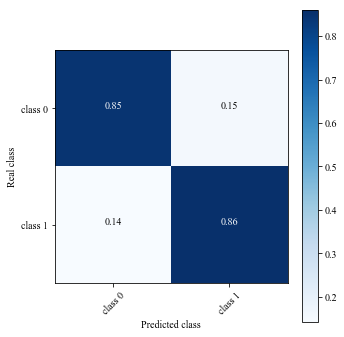

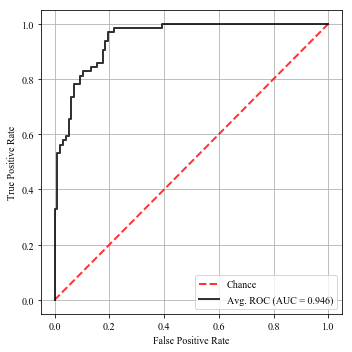

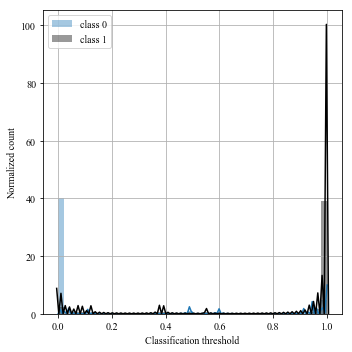

Accuracy:  0.8509316770186336
              precision    recall  f1-score   support

         0.0     0.9011    0.8454    0.8723        97
         1.0     0.7857    0.8594    0.8209        64

    accuracy                         0.8509       161
   macro avg     0.8434    0.8524    0.8466       161
weighted avg     0.8552    0.8509    0.8519       161



In [28]:
classify(Xphonation, yArousal)

Epoch: 0 	Training Loss: 0.562844 	Valid Loss: 0.457760 	ACC train 0.793478 	ACC test 0.913043
Validation Accuracy increased (0.000000 --> 0.913043).  Saving model ...


/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 1 	Training Loss: 0.389061 	Valid Loss: 0.381554 	ACC train 0.934783 	ACC test 0.944099
Validation Accuracy increased (0.913043 --> 0.944099).  Saving model ...
Epoch: 2 	Training Loss: 0.344064 	Valid Loss: 0.373976 	ACC train 0.975543 	ACC test 0.944099
Validation Accuracy increased (0.944099 --> 0.944099).  Saving model ...
Epoch: 3 	Training Loss: 0.329644 	Valid Loss: 0.359735 	ACC train 0.980978 	ACC test 0.956522
Validation Accuracy increased (0.944099 --> 0.956522).  Saving model ...
Epoch: 4 	Training Loss: 0.323040 	Valid Loss: 0.358172 	ACC train 0.986413 	ACC test 0.956522
Validation Accuracy increased (0.956522 --> 0.956522).  Saving model ...
Epoch: 5 	Training Loss: 0.319871 	Valid Loss: 0.358411 	ACC train 0.986413 	ACC test 0.956522
Validation Accuracy increased (0.956522 --> 0.956522).  Saving model ...
Epoch: 6 	Training Loss: 0.313152 	Valid Loss: 0.354601 	ACC train 0.997283 	ACC test 0.956522
Validation Accuracy increased (0.956522 --> 0.956522).  Saving mo

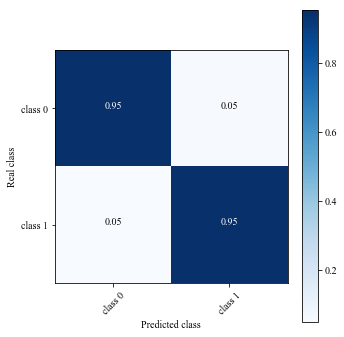

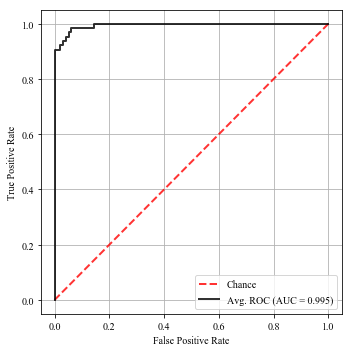

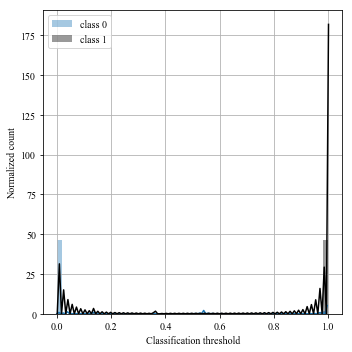

Accuracy:  0.9503105590062112
              precision    recall  f1-score   support

         0.0     0.9684    0.9485    0.9583        97
         1.0     0.9242    0.9531    0.9385        64

    accuracy                         0.9503       161
   macro avg     0.9463    0.9508    0.9484       161
weighted avg     0.9509    0.9503    0.9504       161



In [29]:
classify(Xarticulation, yArousal)

Epoch: 0 	Training Loss: 0.617481 	Valid Loss: 0.549946 	ACC train 0.714674 	ACC test 0.838509
Validation Accuracy increased (0.000000 --> 0.838509).  Saving model ...


/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 1 	Training Loss: 0.472385 	Valid Loss: 0.469780 	ACC train 0.847826 	ACC test 0.844720
Validation Accuracy increased (0.838509 --> 0.844720).  Saving model ...
Epoch: 2 	Training Loss: 0.413470 	Valid Loss: 0.445087 	ACC train 0.902174 	ACC test 0.869565
Validation Accuracy increased (0.844720 --> 0.869565).  Saving model ...
Epoch: 3 	Training Loss: 0.381649 	Valid Loss: 0.433170 	ACC train 0.926630 	ACC test 0.875776
Validation Accuracy increased (0.869565 --> 0.875776).  Saving model ...
Epoch: 4 	Training Loss: 0.359166 	Valid Loss: 0.423880 	ACC train 0.953804 	ACC test 0.875776
Validation Accuracy increased (0.875776 --> 0.875776).  Saving model ...
Epoch: 5 	Training Loss: 0.348515 	Valid Loss: 0.425460 	ACC train 0.970109 	ACC test 0.875776
Validation Accuracy increased (0.875776 --> 0.875776).  Saving model ...
Epoch: 6 	Training Loss: 0.338467 	Valid Loss: 0.420200 	ACC train 0.972826 	ACC test 0.888199
Validation Accuracy increased (0.875776 --> 0.888199).  Saving mo

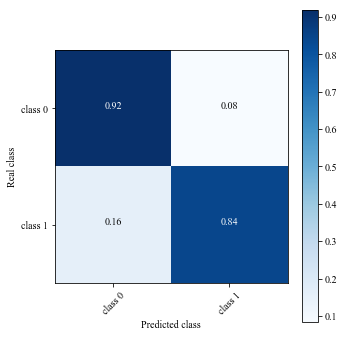

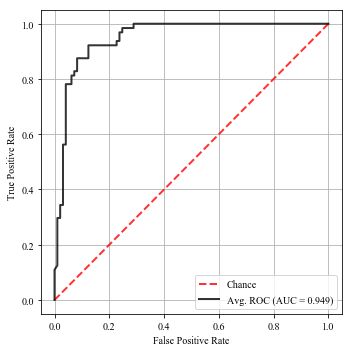

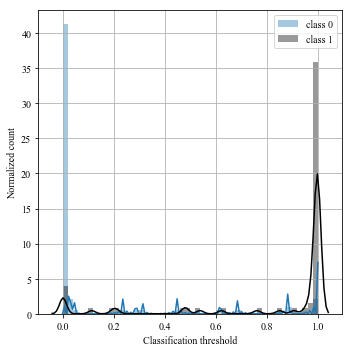

Accuracy:  0.8881987577639752
              precision    recall  f1-score   support

         0.0     0.8990    0.9175    0.9082        97
         1.0     0.8710    0.8438    0.8571        64

    accuracy                         0.8882       161
   macro avg     0.8850    0.8806    0.8827       161
weighted avg     0.8879    0.8882    0.8879       161



In [30]:
classify(Xprosody, yArousal)

Epoch: 0 	Training Loss: 0.655445 	Valid Loss: 0.629914 	ACC train 0.646739 	ACC test 0.788820
Validation Accuracy increased (0.000000 --> 0.788820).  Saving model ...


/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 1 	Training Loss: 0.562179 	Valid Loss: 0.531967 	ACC train 0.796196 	ACC test 0.819876
Validation Accuracy increased (0.788820 --> 0.819876).  Saving model ...
Epoch: 2 	Training Loss: 0.481375 	Valid Loss: 0.472702 	ACC train 0.828804 	ACC test 0.844720
Validation Accuracy increased (0.819876 --> 0.844720).  Saving model ...
Epoch: 3 	Training Loss: 0.435548 	Valid Loss: 0.441714 	ACC train 0.885870 	ACC test 0.888199
Validation Accuracy increased (0.844720 --> 0.888199).  Saving model ...
Epoch: 4 	Training Loss: 0.406229 	Valid Loss: 0.424116 	ACC train 0.904891 	ACC test 0.894410
Validation Accuracy increased (0.888199 --> 0.894410).  Saving model ...
Epoch: 5 	Training Loss: 0.397975 	Valid Loss: 0.416474 	ACC train 0.913043 	ACC test 0.919255
Validation Accuracy increased (0.894410 --> 0.919255).  Saving model ...
Epoch: 6 	Training Loss: 0.381681 	Valid Loss: 0.415738 	ACC train 0.932065 	ACC test 0.919255
Validation Accuracy increased (0.919255 --> 0.919255).  Saving mo

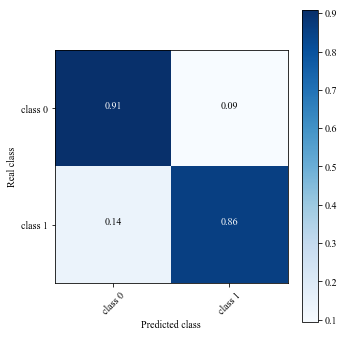

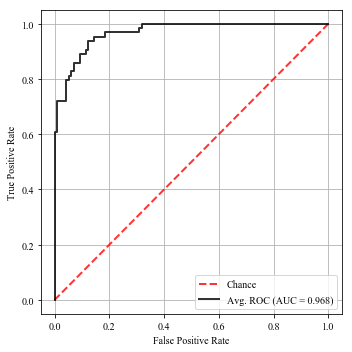

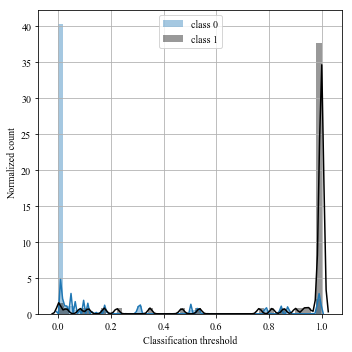

Accuracy:  0.8881987577639752
              precision    recall  f1-score   support

         0.0     0.9072    0.9072    0.9072        97
         1.0     0.8594    0.8594    0.8594        64

    accuracy                         0.8882       161
   macro avg     0.8833    0.8833    0.8833       161
weighted avg     0.8882    0.8882    0.8882       161



In [31]:
classify(Xphonological, yArousal)

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.500382 	Valid Loss: 0.430194 	ACC train 0.847826 	ACC test 0.881988
Validation Accuracy increased (0.000000 --> 0.881988).  Saving model ...
Epoch: 1 	Training Loss: 0.361214 	Valid Loss: 0.393376 	ACC train 0.934783 	ACC test 0.925466
Validation Accuracy increased (0.881988 --> 0.925466).  Saving model ...
Epoch: 2 	Training Loss: 0.327578 	Valid Loss: 0.387862 	ACC train 0.986413 	ACC test 0.913043
Epoch: 3 	Training Loss: 0.316949 	Valid Loss: 0.355853 	ACC train 0.994565 	ACC test 0.962733
Validation Accuracy increased (0.925466 --> 0.962733).  Saving model ...
Epoch: 4 	Training Loss: 0.310851 	Valid Loss: 0.368096 	ACC train 1.000000 	ACC test 0.937888
Epoch: 5 	Training Loss: 0.310603 	Valid Loss: 0.382773 	ACC train 0.997283 	ACC test 0.925466
Epoch: 6 	Training Loss: 0.308930 	Valid Loss: 0.384760 	ACC train 1.000000 	ACC test 0.925466
Epoch: 7 	Training Loss: 0.308863 	Valid Loss: 0.379705 	ACC train 1.000000 	ACC test 0.925466
Epoch: 8 	Training Lo

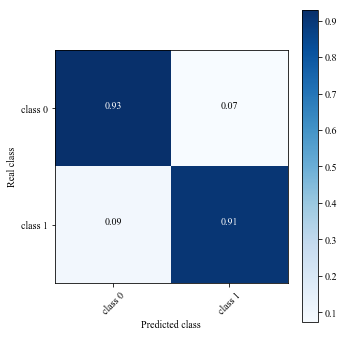

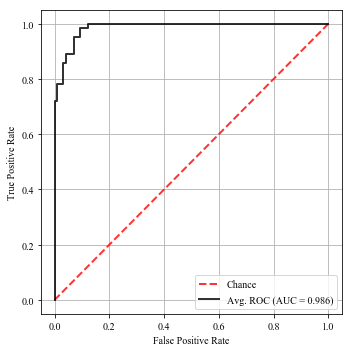

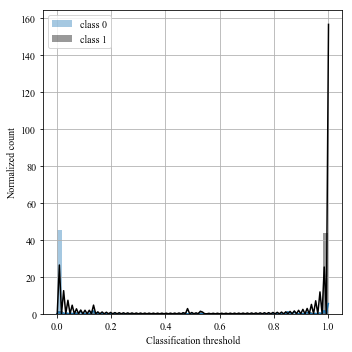

Accuracy:  0.9192546583850931
              precision    recall  f1-score   support

         0.0     0.9375    0.9278    0.9326        97
         1.0     0.8923    0.9062    0.8992        64

    accuracy                         0.9193       161
   macro avg     0.9149    0.9170    0.9159       161
weighted avg     0.9195    0.9193    0.9194       161



In [32]:
classify(Xrep, yArousal)

## classify positive vs. negative valence with the different feature sets

Epoch: 0 	Training Loss: 0.681314 	Valid Loss: 0.673568 	ACC train 0.494565 	ACC test 0.701863
Validation Accuracy increased (0.000000 --> 0.701863).  Saving model ...


/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 1 	Training Loss: 0.671363 	Valid Loss: 0.666985 	ACC train 0.673913 	ACC test 0.708075
Validation Accuracy increased (0.701863 --> 0.708075).  Saving model ...
Epoch: 2 	Training Loss: 0.666432 	Valid Loss: 0.664462 	ACC train 0.695652 	ACC test 0.701863
Epoch: 3 	Training Loss: 0.661509 	Valid Loss: 0.665339 	ACC train 0.698370 	ACC test 0.652174
Epoch: 4 	Training Loss: 0.652614 	Valid Loss: 0.662281 	ACC train 0.695652 	ACC test 0.670807
Epoch: 5 	Training Loss: 0.645642 	Valid Loss: 0.661541 	ACC train 0.679348 	ACC test 0.670807
Epoch: 6 	Training Loss: 0.631084 	Valid Loss: 0.656243 	ACC train 0.722826 	ACC test 0.677019
Epoch: 7 	Training Loss: 0.615624 	Valid Loss: 0.654172 	ACC train 0.720109 	ACC test 0.683230
Epoch: 8 	Training Loss: 0.609962 	Valid Loss: 0.641694 	ACC train 0.739130 	ACC test 0.677019
Epoch: 9 	Training Loss: 0.590145 	Valid Loss: 0.650743 	ACC train 0.728261 	ACC test 0.677019
Epoch: 10 	Training Loss: 0.581740 	Valid Loss: 0.633583 	ACC train 0.75

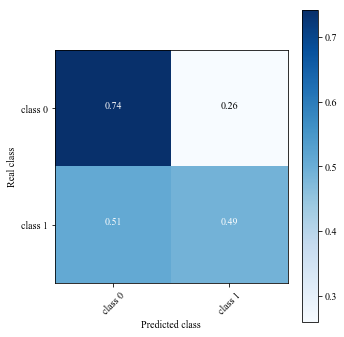

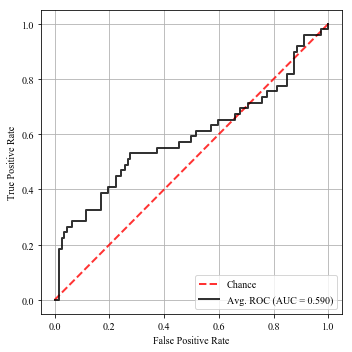

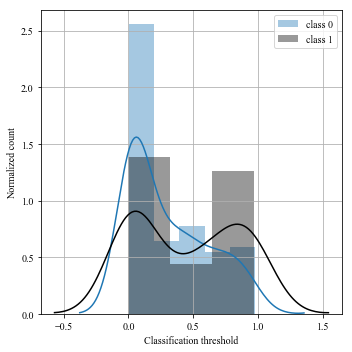

Accuracy:  0.6645962732919255
              precision    recall  f1-score   support

         0.0     0.7685    0.7411    0.7545       112
         1.0     0.4528    0.4898    0.4706        49

    accuracy                         0.6646       161
   macro avg     0.6107    0.6154    0.6126       161
weighted avg     0.6724    0.6646    0.6681       161



In [33]:
classify(Xphonation, yValence)

Epoch: 0 	Training Loss: 0.654075 	Valid Loss: 0.609802 	ACC train 0.703804 	ACC test 0.683230
Validation Accuracy increased (0.000000 --> 0.683230).  Saving model ...


/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 1 	Training Loss: 0.547831 	Valid Loss: 0.573420 	ACC train 0.836957 	ACC test 0.745342
Validation Accuracy increased (0.683230 --> 0.745342).  Saving model ...
Epoch: 2 	Training Loss: 0.449804 	Valid Loss: 0.545747 	ACC train 0.902174 	ACC test 0.782609
Validation Accuracy increased (0.745342 --> 0.782609).  Saving model ...
Epoch: 3 	Training Loss: 0.383427 	Valid Loss: 0.543458 	ACC train 0.951087 	ACC test 0.770186
Epoch: 4 	Training Loss: 0.340624 	Valid Loss: 0.541483 	ACC train 0.978261 	ACC test 0.751553
Epoch: 5 	Training Loss: 0.328871 	Valid Loss: 0.547033 	ACC train 0.986413 	ACC test 0.757764
Epoch: 6 	Training Loss: 0.322512 	Valid Loss: 0.540059 	ACC train 0.991848 	ACC test 0.782609
Validation Accuracy increased (0.782609 --> 0.782609).  Saving model ...
Epoch: 7 	Training Loss: 0.316446 	Valid Loss: 0.539279 	ACC train 0.994565 	ACC test 0.776398
Epoch: 8 	Training Loss: 0.314359 	Valid Loss: 0.538861 	ACC train 0.997283 	ACC test 0.763975
Epoch: 9 	Training Lo

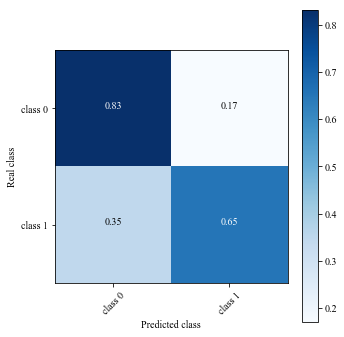

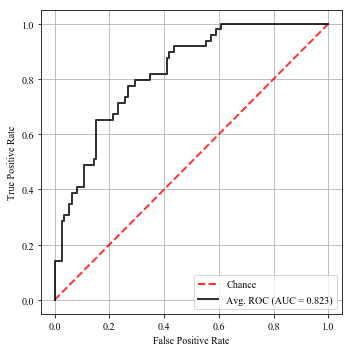

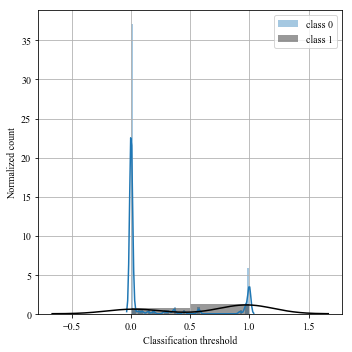

Accuracy:  0.7763975155279503
              precision    recall  f1-score   support

         0.0     0.8455    0.8304    0.8378       112
         1.0     0.6275    0.6531    0.6400        49

    accuracy                         0.7764       161
   macro avg     0.7365    0.7417    0.7389       161
weighted avg     0.7791    0.7764    0.7776       161



In [34]:
classify(Xarticulation, yValence)

Epoch: 0 	Training Loss: 0.672757 	Valid Loss: 0.652485 	ACC train 0.633152 	ACC test 0.701863
Validation Accuracy increased (0.000000 --> 0.701863).  Saving model ...


/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 1 	Training Loss: 0.637652 	Valid Loss: 0.622449 	ACC train 0.744565 	ACC test 0.689441
Epoch: 2 	Training Loss: 0.597057 	Valid Loss: 0.609627 	ACC train 0.698370 	ACC test 0.689441
Epoch: 3 	Training Loss: 0.567202 	Valid Loss: 0.591895 	ACC train 0.725543 	ACC test 0.689441
Epoch: 4 	Training Loss: 0.528877 	Valid Loss: 0.580324 	ACC train 0.788043 	ACC test 0.683230
Epoch: 5 	Training Loss: 0.492093 	Valid Loss: 0.577688 	ACC train 0.801630 	ACC test 0.695652
Epoch: 6 	Training Loss: 0.468022 	Valid Loss: 0.584861 	ACC train 0.831522 	ACC test 0.677019
Epoch: 7 	Training Loss: 0.439834 	Valid Loss: 0.579124 	ACC train 0.883152 	ACC test 0.714286
Validation Accuracy increased (0.701863 --> 0.714286).  Saving model ...
Epoch: 8 	Training Loss: 0.417330 	Valid Loss: 0.580934 	ACC train 0.907609 	ACC test 0.683230
Epoch: 9 	Training Loss: 0.404423 	Valid Loss: 0.591209 	ACC train 0.913043 	ACC test 0.683230
Epoch: 10 	Training Loss: 0.408085 	Valid Loss: 0.603642 	ACC train 0.91

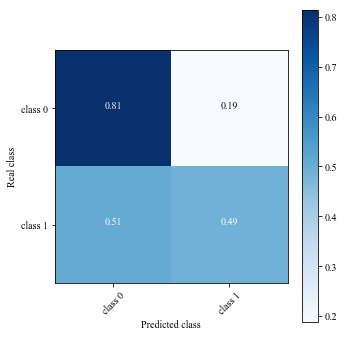

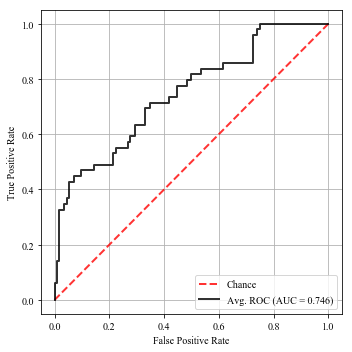

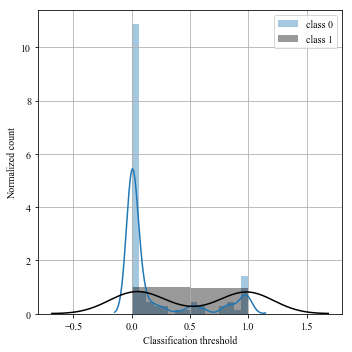

Accuracy:  0.7142857142857143
              precision    recall  f1-score   support

         0.0     0.7845    0.8125    0.7982       112
         1.0     0.5333    0.4898    0.5106        49

    accuracy                         0.7143       161
   macro avg     0.6589    0.6511    0.6544       161
weighted avg     0.7080    0.7143    0.7107       161



In [35]:
classify(Xprosody, yValence)

Epoch: 0 	Training Loss: 0.666929 	Valid Loss: 0.645199 	ACC train 0.567935 	ACC test 0.714286
Validation Accuracy increased (0.000000 --> 0.714286).  Saving model ...


/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 1 	Training Loss: 0.618307 	Valid Loss: 0.605402 	ACC train 0.730978 	ACC test 0.720497
Validation Accuracy increased (0.714286 --> 0.720497).  Saving model ...
Epoch: 2 	Training Loss: 0.578396 	Valid Loss: 0.582278 	ACC train 0.739130 	ACC test 0.714286
Epoch: 3 	Training Loss: 0.536781 	Valid Loss: 0.562184 	ACC train 0.798913 	ACC test 0.745342
Validation Accuracy increased (0.720497 --> 0.745342).  Saving model ...
Epoch: 4 	Training Loss: 0.507895 	Valid Loss: 0.545942 	ACC train 0.828804 	ACC test 0.745342
Validation Accuracy increased (0.745342 --> 0.745342).  Saving model ...
Epoch: 5 	Training Loss: 0.482157 	Valid Loss: 0.554347 	ACC train 0.858696 	ACC test 0.739130
Epoch: 6 	Training Loss: 0.458936 	Valid Loss: 0.542739 	ACC train 0.853261 	ACC test 0.751553
Validation Accuracy increased (0.745342 --> 0.751553).  Saving model ...
Epoch: 7 	Training Loss: 0.432011 	Valid Loss: 0.547776 	ACC train 0.899457 	ACC test 0.739130
Epoch: 8 	Training Loss: 0.416783 	Valid Lo

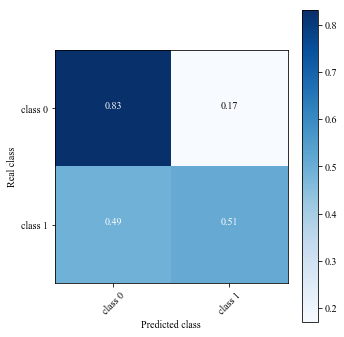

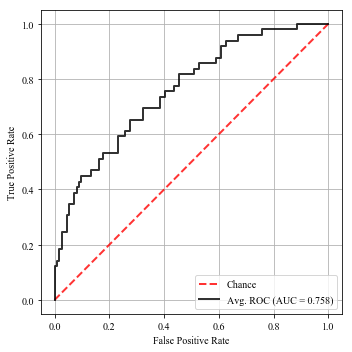

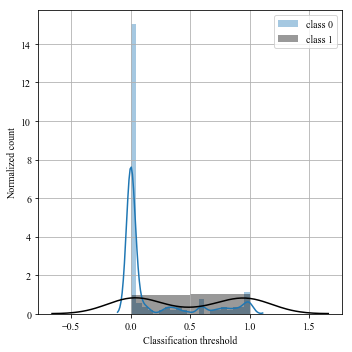

Accuracy:  0.7329192546583851
              precision    recall  f1-score   support

         0.0     0.7949    0.8304    0.8122       112
         1.0     0.5682    0.5102    0.5376        49

    accuracy                         0.7329       161
   macro avg     0.6815    0.6703    0.6749       161
weighted avg     0.7259    0.7329    0.7287       161



In [36]:
classify(Xphonological, yValence)

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.641576 	Valid Loss: 0.577312 	ACC train 0.633152 	ACC test 0.745342
Validation Accuracy increased (0.000000 --> 0.745342).  Saving model ...
Epoch: 1 	Training Loss: 0.495647 	Valid Loss: 0.542601 	ACC train 0.845109 	ACC test 0.770186
Validation Accuracy increased (0.745342 --> 0.770186).  Saving model ...
Epoch: 2 	Training Loss: 0.403189 	Valid Loss: 0.497890 	ACC train 0.923913 	ACC test 0.801242
Validation Accuracy increased (0.770186 --> 0.801242).  Saving model ...
Epoch: 3 	Training Loss: 0.352646 	Valid Loss: 0.479816 	ACC train 0.961957 	ACC test 0.844720
Validation Accuracy increased (0.801242 --> 0.844720).  Saving model ...
Epoch: 4 	Training Loss: 0.338053 	Valid Loss: 0.498315 	ACC train 0.978261 	ACC test 0.801242
Epoch: 5 	Training Loss: 0.329719 	Valid Loss: 0.476651 	ACC train 0.983696 	ACC test 0.832298
Epoch: 6 	Training Loss: 0.325157 	Valid Loss: 0.468913 	ACC train 0.989130 	ACC test 0.838509
Epoch: 7 	Training Loss: 0.320663 	Valid Lo

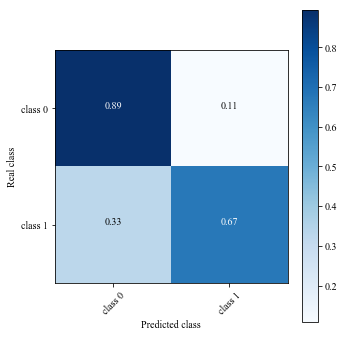

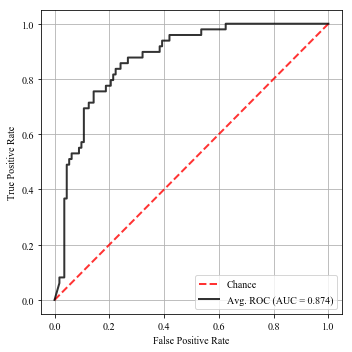

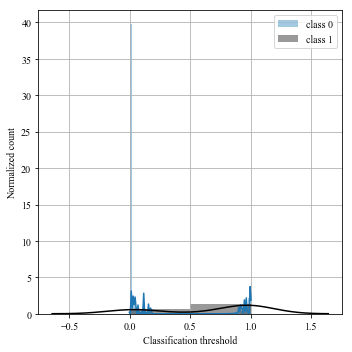

Accuracy:  0.8260869565217391
              precision    recall  f1-score   support

         0.0     0.8621    0.8929    0.8772       112
         1.0     0.7333    0.6735    0.7021        49

    accuracy                         0.8261       161
   macro avg     0.7977    0.7832    0.7897       161
weighted avg     0.8229    0.8261    0.8239       161



In [37]:
classify(Xrep, yValence)